In [326]:
import os
from graspy.simulations import sbm
from graspy.plot import heatmap, pairplot
from graspy.embed import AdjacencySpectralEmbed, select_dimension
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from src.cluster import BinaryCluster
import pandas as pd
from collections import Counter
import seaborn as sns
import pandas as pd


In [327]:
from pathlib import Path
def savefig(
    name,
    fmt="png",
    dpi=300,
    foldername=None,
    subfoldername="outs",
    pathname="/Users/TingshanLiu/Desktop/2020 summer/TL_maggot",
    bbox_inches="tight",
    pad_inches=0.5,
    save_on=True,
    transparent=False,
    **kws,
):
    if save_on:
        path = _handle_dirs(pathname, foldername, subfoldername)
        savename = path / str(name + "." + fmt)
        plt.savefig(
            savename,
            format=fmt,
            facecolor="white",
            transparent=transparent,
            bbox_inches=bbox_inches,
            pad_inches=pad_inches,
            dpi=dpi,
            **kws,
        )
        print(f"Saved figure to {savename}")

def _handle_dirs(pathname, foldername, subfoldername):
    path = Path(pathname)
    if foldername is not None:
        path = path / foldername
        if not os.path.isdir(path):
            os.mkdir(path)
        if subfoldername is not None:
            path = path / subfoldername
            if not os.path.isdir(path):
                os.mkdir(path)
    return path

def savecsv(
    df,
    name,
    foldername=None,
    subfoldername="csvs",
    pathname="/Users/TingshanLiu/Desktop/2020 summer/TL_maggot",
    save_on=True,
):
    if save_on:
        path = _handle_dirs(pathname, foldername, subfoldername)
        savename = path / str(name + ".csv")
        df.to_csv(savename)
        print(f"Saved DataFrame to {savename}")



FNAME = os.path.basename('/Users/TingshanLiu/Desktop/2020 summer/TL_maggot/maggot_repo/maggot_models')

def stashfig(name, **kws):
    savefig(name, foldername = FNAME, save_on = True, **kws)
    
def stashcsv(df, name, **kws):
    savecsv(df, name, foldername=FNAME, **kws)

In [4]:
def undirected_p(nclusters):
    p = np.zeros([nclusters, nclusters])
    for i in range(nclusters):
        for j in range(i,nclusters):
            if i == j:
                p[i,j] = np.random.uniform(0.8, 1)
            # first-off-diagonal alone
            elif j - i == 1:
                p[i,j] = np.random.uniform(0.2, 0.6)
                p[j,i] = p[i,j]

            # second-off-diagonal alone
            elif j - i == 2:
                p[i,j] = np.random.uniform(0.2, 0.6)
                p[j,i] = p[i,j]

            # third-off-diagonal alone
            # elif j - i == 3:
            #     p[i,j] = np.random.uniform(off1, off1 + 0.05)
            #     p[j,i] = p[i,j]

            # off-diagonal bulk
            else: 
                p[i,j] = np.random.uniform(0, 0.2)
                p[j,i] = p[i,j]

    return p

def direct_p(nclusters):
    p = np.random.rand(nclusters,nclusters).round(decimals = 3)

    return p

In [366]:
# 1st/2nd/3rd off-diag = mean of adjacent on-diags

def undirected_p(nclusters, on1):
    p = np.zeros([nclusters, nclusters])
    for i in range(nclusters):
        p[i,i] = np.random.uniform(on1, 1)
    for i in range(nclusters):
        for j in range(i,nclusters):
            # first-off diagonal 
            if  j - i == 1:
                #p[i,j] = (p[i,i] + p[j,j]) / 4
                p[i,j] = np.random.uniform(0, 0.3)
                p[j,i] = p[i,j]

            # off-diagonal bulk
            elif j - i > 1: 
                p[i,j] = np.random.uniform(0, 0.3)
                p[j,i] = p[i,j]

    return p

In [356]:
# 1st off-diag = mean of adjacent on-diags & 2nd-diag = mean of adjacent 1st off-diags

def undirected_p(nclusters, on1):
    p = np.zeros([nclusters, nclusters])
    for i in range(nclusters):
        p[i,i] = np.random.uniform(on1, 1)
    for i in range(nclusters):
        for j in range(i,nclusters):
            # first-off diagonal 
            if  j - i == 1:
                p[i,j] = (p[i,i] + p[j,j]) / 2
                p[j,i] = p[i,j]

    for i in range(nclusters):
        for j in range(i,nclusters):
            # 2nd-off diagonal 
            if  j - i == 2:
                p[i,j] = (p[i,j-1] + p[i+1,j]) / 2
                p[j,i] = p[i,j]

            # off-diagonal bulk
            elif j - i > 2: 
                p[i,j] = np.random.uniform(0, 0.3)
                p[j,i] = p[i,j]

    return p

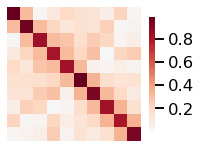

In [96]:
heatmap(undirected_p(len(n),0.3), figsize= (3,3))

In [7]:
def cluster_score(labels, nclusters, size):
    score = np.ones(nclusters)
    for i in np.arange(1, len(score)+1):
        labels_pred = labels[size * (i-1): size * i]
        score[i-1] = max(Counter(labels_pred).most_common(), key = lambda item: item[1])[1]
    return np.mean(score) / size

In [5]:
label_true = []
ncluster = 5
size = 20

for i in range(ncluster):
    label_true = np.concatenate((label_true, np.ones(size)+i))

In [6]:
def ica_score(G, ite, d, k):
    score = np.zeros([ite, 3])
    for i in range(ite):
        #p = undirected_p(len(n))
        #G = sbm(n= n, p= p)
        ica = FastICA(algorithm = "parallel", max_iter=1000, n_components= d)
        embed = ica.fit_transform(G)
        labels = KMeans(n_clusters= k).fit(embed).labels_
        #score[i,0] = cluster_score(labels, len(n), n[0])
        #score[i,1] = silhouette_score(embed, labels)
        score[i,2] = adjusted_rand_score(label_true, labels)

    return np.mean(score[:, 2])

In [7]:
def ase_score(G, ite, d, k):
    score = np.zeros([ite, 3])
    for i in range(ite):
        #p = undirected_p(len(n))
        #G = sbm(n= n, p= p)
        #ase = AdjacencySpectralEmbed(n_components= d)
        ase = AdjacencySpectralEmbed()
        embed = ase.fit_transform(G)
        labels = KMeans(n_clusters= k).fit(embed).labels_
        #score[i,0] = cluster_score(labels, len(n), n[0])
        #score[i,1] = silhouette_score(embed, labels)
        score[i,2] = adjusted_rand_score(label_true, labels)

    return np.mean(score[:, 2])

In [329]:
# fixed prob interval

ncluster = 10
k = ncluster
n = np.repeat(size, ncluster)
ite = 10
#dims = np.arange(3, 11)
probs = np.arange(0.3, 0.8, 0.05)
#score_ase_mean = np.zeros(len(dims))
#score_ica_mean = np.zeros(len(dims))
#idx = 0

score_ase = np.zeros([len(probs), 3]) #score_ase = np.zeros([len(probs), len(dims)])
score_ica = np.zeros([len(probs), 3]) #score_ica = np.zeros([len(probs), len(dims)])

# varying embedding dimensions
# for d in dims:
#     for i in range(len(probs)):
#         score_ase[i, idx]  = ase_score(n, probs[i], ite, d, k)
#         score_ica[i, idx]  = ica_score(n, probs[i], ite, d, k)
    
#     #score_ase_mean[idx] = np.mean(score_ase)
#     #score_ica_mean[idx] = np.mean(score_ica)
#     idx = idx + 1


# fixed embedding dimensions: d = k for ICA, d is selected w/ select_dimension
d = k
for i in range(len(probs)):
    score_ase[i, :]  = ase_score(n, probs[i], ite, d, k)
    score_ica[i, :]  = ica_score(n, probs[i], ite, d, k)
    

In [330]:
# various prob interval

ncluster = 5
k = ncluster
n = np.repeat(size, ncluster)
ite = 3000
prob_on = np.zeros([ite, 1])
prob_off = np.zeros([ite, 1])
off_len = (ncluster - 1) + (ncluster - 2)
#dims = np.arange(3, 11)

score_ase = np.zeros([ite, 1]) #score_ase = np.zeros([len(probs), len(dims)])
score_ica = np.zeros([ite, 1]) #score_ica = np.zeros([len(probs), len(dims)])


d = k
for i in range(ite):
    p = undirected_p(len(n))
    G = sbm(n= n, p= p)
    prob_on[i] = np.mean(np.diag(p))
    off_diags = np.zeros(off_len)
    idx = 0
    for j in np.array([1, 2]): # 1st- and 2nd-off-diagonal
        for k in np.arange(j, ncluster):
            off_diags[idx] = p[k, k-j]
            idx = idx + 1
    prob_off[i] = np.mean(off_diags)
    score_ase[i]  = ase_score(G, 1, d, k)
    score_ica[i]  = ica_score(G, 1, d, k)
    
    

In [292]:
score = pd.DataFrame(np.concatenate((np.reshape(prob_on, (len(score_ica),1)), np.reshape(prob_off, (len(score_ica),1)), score_ica-score_ase), axis = 1))
score.rename(columns={2: "ARI"}, inplace=True)
score.rename(columns={0: "prob_on"}, inplace=True)
score.rename(columns={1: "prob_off"}, inplace=True)
score["prob_off"] = score["prob_off"].round(decimals=3)
score["prob_on"] = score["prob_on"].round(decimals=3)
prob_on_round = prob_on.round(decimals=3)
prob_off_round = prob_off.round(decimals=3)
score_diff = score_ica-score_ase

In [323]:
a = np.arange(min(prob_on_round), max(prob_on_round), 0.001).round(decimals = 3)
b = np.arange(min(prob_off_round), max(prob_off_round), 0.001).round(decimals = 3)
A,B = np.meshgrid(a,b)

In [328]:
score_grid = np.zeros((A.shape[0], A.shape[1])) + 100

for i in range(len(score_diff)):
    idx1 = np.where(b == prob_off_round[i])
    idx2 = np.where(a == prob_on_round[i])
    score_grid[idx1, idx2] = score_diff[i]

#sns.heatmap(score_grid, vmax = max(score_diff), vmin = min(score_diff))

In [97]:
# fig, (ax1, ax2) = plt.subplots(1,2)
# sns.heatmap(np.transpose(score_ase), square = True, ax = ax1)
# sns.heatmap(np.transpose(score_ica), square = True, ax = ax2)

#plt.show()

In [118]:
#stashcsv(score_diff, "ARI-ICA-ASE-OnDiag=[0`6,0`8]")

Saved DataFrame to /Users/TingshanLiu/Desktop/2020 summer/TL_maggot/maggot_models/csvs/ARI-ICA-ASE-OnDiag=[0`6,0`8].csv


In [98]:
sns.set(font_scale = 1)
fig, ax = plt.subplots(1,1, figsize = (8,6))
heat_map = sns.heatmap(np.transpose(score_ica - score_ase), square = True, xticklabels = probs.round(decimals = 2), yticklabels = dims)
ax.set_xlabel("1st-off-diag prob interval")
ax.set_ylabel("ndimensions")

#stashfig("SBM20*10-ARI-ICAminusASE-OnDiag=[0`6,0`8]-1stOff=[0`3,0`8,0`05]-d=[3,10]-k=10")

In [ ]:
# plot lines: score versus prob interval

In [90]:
score = pd.DataFrame(np.concatenate((score_ase, score_ica)))
name = [["ASE"], ["ICA"]]
name = np.tile(name , (1,len(probs)))
name = np.reshape(name, (2 * len(probs),1))
score["method"] = name
score["prob"] = np.reshape(np.concatenate((probs, probs)), (2 * len(probs),1))

In [322]:
fig = plt.figure(constrained_layout = True, figsize = (12,6))
gs = fig.add_gridspec(2, 3)
ax1 = fig.add_subplot(gs[0,:-1])
ax2 = fig.add_subplot(gs[1,:-1])
ax3 = fig.add_subplot(gs[1,2])
sns.lineplot(x = "prob", y = 0, hue = 'method', style= 'method', ax = ax1, data = score)
sns.lineplot(x = "prob", y = 2, hue = 'method', style= 'method', ax = ax2, data = score)
heatmap(undirected_p(len(n), 0.8), ax = ax3)
ax1.set_xlabel("")
ax1.set_ylabel("Percent of Perfect Cluster")
ax2.set_xlabel("On-diagonal Probability")
ax2.set_ylabel("Silhouette Score")
ax3.set_xlabel("On-diag prob = [0.8, 1] * \n bulk off-diag prob = [0, 0.3] \n  1st-off-diag prob \n = mean of adjacent on-diag probs \n 2nd-off-diag prob \n = mean of adjacent 1st-off-diag probs ")

#stashfig("SBM-ASE-ICA-OnDiag=[0`6,0`9,0`05]-1st=mean_adj_On-2nd=mean_1st-OffBulk[0,0`3]")


Saved figure to /Users/TingshanLiu/Desktop/2020 summer/TL_maggot/maggot_models/outs/SBM-ASEOptimal_d-ICAd=k-OnDiag=[0`8,1]-1stOff=[0`2,0`8,0`05]-OffBulk[0,0`2].png


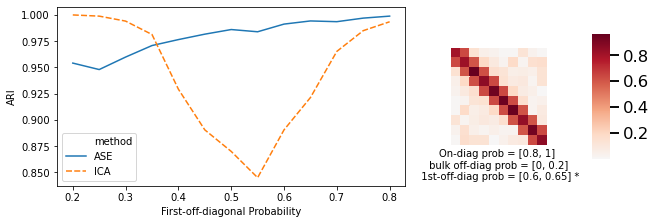

In [84]:
fig = plt.figure(constrained_layout = True, figsize = (9,3))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0,:-1])
ax3 = fig.add_subplot(gs[0,2])
sns.lineplot(x = "prob", y = 0, hue = 'method', style= 'method', ax = ax1, data = score)
heatmap(undirected_p(len(n), 0.6), ax = ax3)
ax1.set_ylabel("ARI")
ax1.set_xlabel("First-off-diagonal Probability")
ax3.set_xlabel("On-diag prob = [0.8, 1] \n bulk off-diag prob = [0, 0.2] \n  1st-off-diag prob = [0.6, 0.65] * ")

stashfig("SBM-ASEOptimal_d-ICAd=k-OnDiag=[0`8,1]-1stOff=[0`2,0`8,0`05]-OffBulk[0,0`2]")